<a href="https://colab.research.google.com/github/kalebmes/ML-and-DL-projects/blob/main/Facial%20expression%20recognition%20project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install necessary modules
!pip install kaggle
!pip install timm

     |████████████████████████████████| 431 kB 5.3 MB/s 


In [ ]:
#mount your drive first - you can do it once
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#before executing the code cell below, first download the 'kaggle.json' file from your kaggle's account and upload it to your drive:
#steps
#go to https://www.kaggle.com/<your-kaggle-username>/account -> example.... kaggle.com/kalebasfaw/account
#then ctrl + F => 'create new API token'
#then after downloading that file, upload it to your google drive

In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download challenges-in-representation-learning-facial-expression-recognition-challenge

 93% 266M/285M [00:01<00:00, 216MB/s]
100% 285M/285M [00:01<00:00, 203MB/s]


In [ ]:
#let's get the csv files from the zip file
data_path = "/content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip"
from zipfile import ZipFile
with ZipFile(data_path) as myzip:
  train_data = myzip.open('train.csv')
  test_data = myzip.open('test.csv') #this is used for testing the data, it doesn't contain the labels
  

In [ ]:
#importing necessary modules
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torchvision.datasets as dset
import torchvision.transforms as T

In [ ]:
#loading our data into pandas data frame
train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data) #not used for this task, only for testing, and ranking

In [ ]:
#shuffle indices into training set and test sets and separate the validation data from the training data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df['pixels'], train_df['emotion'], test_size=0.2, shuffle=True)

In [ ]:
#convert each of the training and the validation datasets into dataframes
new_train = pd.DataFrame(data=X_train)
new_train['emotion'] = y_train
new_val = pd.DataFrame(data=X_val)
new_val['emotion'] = y_val

In [ ]:
#now make directories to store each of the images of each categories from the pixels
os.mkdir('/content/fer_images')
os.mkdir('/content/fer_images/train')
os.mkdir('/content/fer_images/validation')

In [ ]:
#WARNING - EXECUTE THIS CELL ONLY ONCE, create a directory of each of the emotions
em_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
fer_path = os.path.join('/content', 'fer_images')
os.chdir(fer_path)
train_path = os.path.join(fer_path, 'train')
validation_path = os.path.join(fer_path, 'validation')
for key in em_dict.keys():
  os.chdir(train_path)
  os.mkdir(em_dict[key])
  os.chdir(validation_path)
  os.mkdir(em_dict[key])

In [ ]:
#save the images into each of the folders of their respective emotions
##saving each images on the training set
counter_each = {'angry': 0, 'sad': 0, 'happy': 0, 'neutral': 0, 'disgust': 0, 'fear': 0, 'surprise': 0}
for (ind, row) in new_train.iterrows():
  emotion = em_dict[row['emotion']]
  emotion_path = os.path.join(train_path, emotion)
  img = np.fromstring(row['pixels'], dtype='uint8', sep=' ')
  img = img.reshape((48, 48))
  image = Image.fromarray(img)
  counter_each[emotion] += 1
  filename = f'{emotion}{counter_each[emotion]}.jpg'
  image_path = os.path.join(emotion_path, filename)
  image.save(image_path)
  # print('saved: ', filename, 'in the training set on the path: ', image_path)

In [ ]:
##saving each images on the validation set
counter_each = {'angry': 0, 'sad': 0, 'happy': 0, 'neutral': 0, 'disgust': 0, 'fear': 0, 'surprise': 0}
for (ind, row) in new_val.iterrows():
  emotion = em_dict[row['emotion']]
  emotion_path = os.path.join(validation_path, emotion)
  img = np.fromstring(row['pixels'], dtype='uint8', sep=' ')
  img = img.reshape((48, 48))
  image = Image.fromarray(img)
  counter_each[emotion] += 1
  filename = f'{emotion}{counter_each[emotion]}.jpg'
  image_path = os.path.join(emotion_path, filename)  
  image.save(image_path)
  # print('saved: ', filename, 'in the validation set on the path: ', image_path)

In [ ]:
#hyperparameters
lr = 1e-3
batch_size = 32
epochs = 3

#device
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  print('GPU available')
else:
  print('training is done on CPU')

GPU available


In [ ]:
#now let's load the dataset into the 'dataloader' package of pytorch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
#first step is creating an augmentation cell using transforms of pytorch
train_augs = T.Compose([T.RandomHorizontalFlip(p=0.5), 
                        T.RandomRotation(degrees=(-20, +20)), 
                        T.ToTensor()])

valid_augs = T.Compose([T.ToTensor()])

In [ ]:
trainset = ImageFolder(train_path, transform=train_augs)
validset = ImageFolder(validation_path, transform=valid_augs)
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 22967
Total no. of examples in validset : 5742


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


chosen index:  17619


Text(0.5, 1.0, '5')

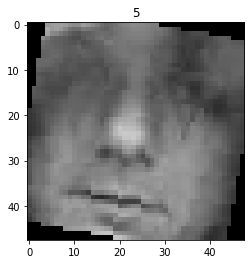

In [ ]:
#we can view some images and their labels
import matplotlib.pyplot as plt
idx = np.random.randint(low=0, high=len(trainset)-1)
print('chosen index: ', idx)
image, label = trainset[idx] # the image has format of h, w, c -> so it have to be reshaped
plt.imshow(image.permute(1, 2, 0))
plt.title(label)

In [ ]:
#now let's read the dataset using pytorch's dataloader
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)
print('total batches in trainloader: ', len(trainloader), 'and validloader: ', len(validloader))

total batches in trainloader:  718 and validloader:  180


In [ ]:
#checking the shapes of each batch
for images, labels in trainloader:
  break
print(f'shape of a batch of images: {images.shape}')
print(f'shape of a batch of labels: {labels.shape}')

shape of a batch of images: torch.Size([32, 3, 48, 48])
shape of a batch of labels: torch.Size([32])


In [ ]:
#create a model
import timm
from torch import nn as nn
from torchvision import models
class FacialClassification(nn.Module):

  def __init__(self):
    super(FacialClassification, self).__init__()

    self.resnet50 = timm.create_model('resnet50', pretrained=False, num_classes=7)
  
  def forward(self, images, labels=None):
    scores = self.resnet50(images)
    if labels!=None:
      loss = nn.CrossEntropyLoss()(scores, labels)
      return scores, loss
    return scores

In [ ]:
# model = FacialClassification()
model = models.resnet50(pretrained=False)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#accuracy of the model
from tqdm import tqdm
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [ ]:
#building the train and eval functions (training the model on the training and on the validation set)
def train_model(model, dataloader, optimizer, current_epoch):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[TRAIN]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    # logits, loss = model(images, labels)
    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

def eval_model(model, dataloader, current_epoch):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc='EPOCH' + '[VALID]' + str(current_epoch + 1) + "/" + str(epochs))

  for t, data in enumerate(tk):
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    # logits, loss = model(images, labels)
    logits = model(images)
    loss = nn.CrossEntropyLoss()(logits, labels)

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss': float(total_loss/(t+1)),'acc': float(total_acc/(t+1))})
  return total_loss/len(dataloader), total_acc / len(dataloader)

In [ ]:
#now let's train the model
from torch import optim
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=1e-2, nesterov=True)

In [ ]:
best_valid_loss = np.Inf
for i in range(epochs):
  train_loss, train_acc = train_model(model, trainloader, optimizer, i)
  valid_loss, valid_acc = eval_model(model, validloader, i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print('SAVED BEST WEIGHTS')
    best_valid_loss = valid_loss
print()
print()
# print('accuracy on the training set: ', float(train_acc))
print('accuracy on the validation set: ', float(valid_acc))

EPOCH[VALID]1/3: 100%|██████████| 180/180 [00:08<00:00, 20.72it/s, loss=1.86, acc=0.212]


SAVED BEST WEIGHTS


EPOCH[VALID]2/3: 100%|██████████| 180/180 [00:08<00:00, 20.84it/s, loss=1.82, acc=0.235]


SAVED BEST WEIGHTS


EPOCH[VALID]3/3: 100%|██████████| 180/180 [00:08<00:00, 21.14it/s, loss=1.81, acc=0.256]


SAVED BEST WEIGHTS


accuracy on the validation set:  0.25577878952026367
